In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# general settings for signal and noise
sample_freq = 1e6  # in Hz
length = 0.2  # in s
signal_power = 0.0  # in dB
noise_power = 5.0  # in dB

# create the signal (the 'soft speaker' kind)
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.soft(f_center=-3e5, power=signal_power, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length, seed=None)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: 0.00 dB
Noise power:  5.00 dB
SNR:          -5.00 dB
Num samples:  200000 


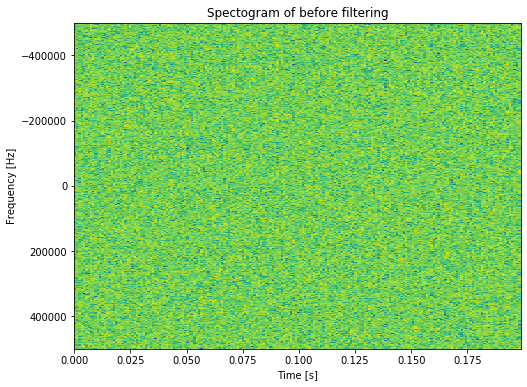

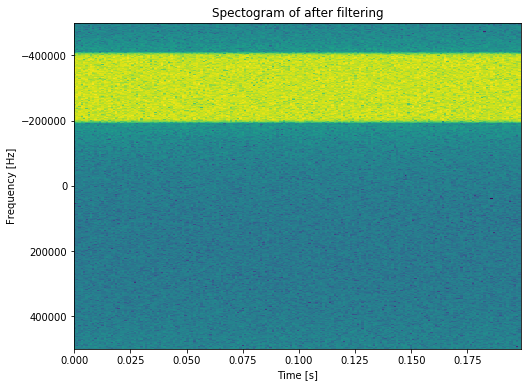

In [3]:
# use the 2d plot function to plot the spectogram
ss.spectrum_plot_2d(sig=noise,
                    f_sample=sample_freq,
                    window='flattop',
                    nfft=1024,
                    title='before filtering')

# apply bandpass filter
noise_fil = ss.filter.fir_bandpass(noise, f_min=-200000, f_max=-400000, f_sample=sample_freq)

# use the 2d plot function to plot the spectogram
ss.spectrum_plot_2d(sig=noise_fil,
                    f_sample=sample_freq,
                    window='flattop',
                    nfft=1024,
                    title='after filtering')

100%|██████████| 199980/199980 [00:02<00:00, 90278.52it/s]


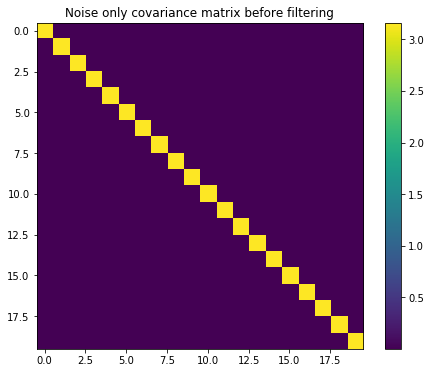

100%|██████████| 199726/199726 [00:02<00:00, 99403.18it/s] 


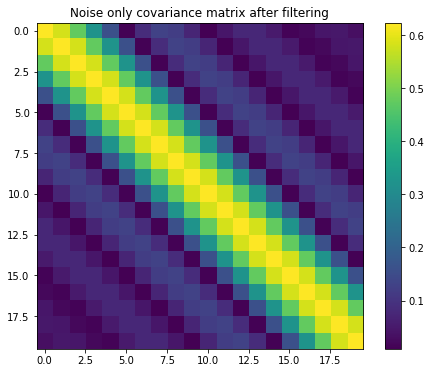

In [4]:
# covariance matrices

plt.figure(figsize=(8, 6))
mat_noise = ss.eigen_detector.corr(x=noise, l=20)
plt.imshow(np.abs(mat_noise))
plt.colorbar()
plt.title('Noise only covariance matrix before filtering')
plt.show()

plt.figure(figsize=(8, 6))
mat_noise_fil = ss.eigen_detector.corr(x=noise_fil, l=20)
plt.imshow(np.abs(mat_noise_fil))
plt.colorbar()
plt.title('Noise only covariance matrix after filtering')
plt.show()

# the filter introduces correlation into the noise -> not good

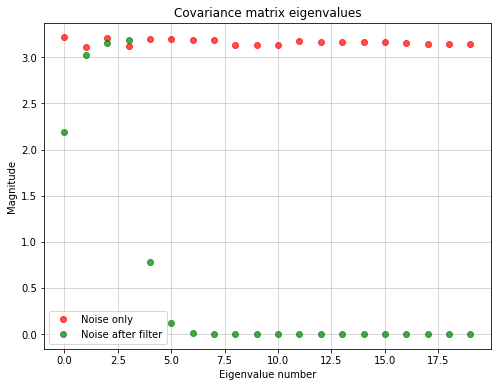

Prob false alarm:   0.0100
Threshold:          1.0287
Noise only mme:     1.0205
Filtered noise mme: 42861862.1598


In [5]:
# plot eigenvalue distribution

# calculate eigenvalues
noise_eig_vals = np.abs(linalg.eigvals(mat_noise))
noise_fil_eig_vals = np.abs(linalg.eigvals(mat_noise_fil))

# and plot them together in one graph
plt.figure(figsize=(8, 6))
plt.plot(noise_eig_vals, 'ro', alpha=0.7, aa=True, label='Noise only')
plt.plot(noise_fil_eig_vals,
         'go',
         alpha=0.7,
         aa=True,
         label='Noise after filter')
plt.xlabel(r'Eigenvalue number')
plt.ylabel(r'Magnitude')
plt.grid(linewidth=0.5)
plt.title('Covariance matrix eigenvalues')
plt.legend(loc=0)
plt.show()

# check what the stats have to say
pfa = 0.01
thr = ss.eigen_stats.mme_thr(Ns=num_samples, L=10, Pfa=pfa)
eng_noise = ss.eigen_detector.mme(x=noise, l=10)
eng_noise_fil = ss.eigen_detector.mme(x=noise_fil, l=10)

print('Prob false alarm:   %.4f' % (pfa))
print('Threshold:          %.4f' % (thr))
print('Noise only mme:     %.4f' % (eng_noise))
print('Filtered noise mme: %.4f' % (eng_noise_fil))

# eigenvalues and stats dont look good -> need to do smth